# Savanna project - fire scar data exploration

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pathlib
import collections
import itertools

import numpy as np

import fiona
import shapely
import odc.geo.geom
import odc.geo.xr
import rioxarray
import rioxarray.merge
import rasterio

In [2]:
fire_scar_dir = pathlib.Path("~/collab/savanna/data/raw/fire_scar/Fire_scars_1989_2023").expanduser()
fire_scar_path = fire_scar_dir / "JW_aust2022faa.shp"

In [3]:
land_cover_dir = pathlib.Path("~/collab/savanna/data/raw/land_cover").expanduser()
land_cover_path = land_cover_dir / "ga_ls_landcover_class_cyear_2_1-0-0_au_x1y-17_2018-01-01_level4.tif"

In [4]:
handle = fiona.open(fire_scar_path)

In [5]:
def geom_from_shape(entry, crs):
    
    if entry.geometry.type == "Polygon":
        (outer, *inners) = entry.geometry.coordinates
        geom = odc.geo.geom.polygon(
            outer,
            crs,
            *inners,
        )
    
    elif entry.geometry.type == "MultiPolygon":
        geom = odc.geo.geom.multipolygon(
            coords=entry.geometry.coordinates,
            crs=crs,
        )
    else:
        raise ValueError()

    return geom

In [6]:
polygons = [
    geom_from_shape(
        entry=entry,
        crs=handle.crs,
    )
    for entry in handle
]

In [7]:
r = [
    odc.geo.xr.rasterize(poly=polygon, how=0.01)
    for polygon in polygons
]

In [8]:
test = [rr.astype(int).rename({"longitude": "x", "latitude":"y"}) for rr in r]

In [15]:
chip = rioxarray.open_rasterio(land_cover_path).isel(band=0, drop=True)

In [12]:
start = odc.geo.xr.rasterize(poly=polygons[0], how=chip.odc.geobox).astype(int)

In [ ]:
for poly in polygons[1:]:
    current = odc.geo.xr.rasterize(poly=poly, how=chip.odc.geobox).astype(int)
    start = rioxarray.merge.merge_arrays([start, current], method=rasterio.merge.copy_sum)

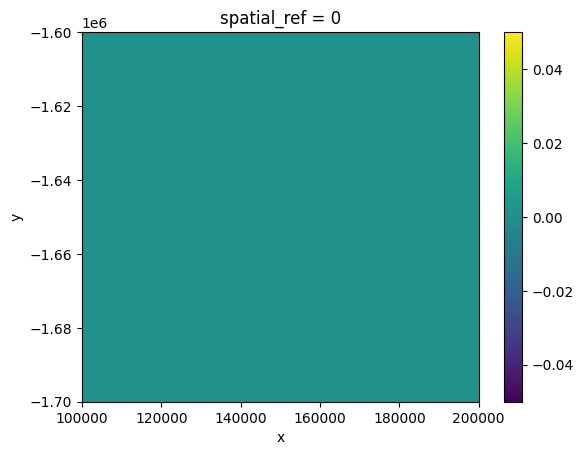

In [11]:
start.plot()

In [ ]:
#r = [
    #odc.geo.xr.rasterize(poly=polygon, how=chip.odc.geobox).astype(int)
    #for polygon in polygons
#]

In [9]:
merged = rioxarray.merge.merge_arrays(test, method=rasterio.merge.copy_sum)

In [13]:
p = polygons[0]

In [34]:
pp = p.to_crs(chip.odc.crs)

In [41]:
pp.intersects(chip.odc.geobox.boundingbox.polygon)

False

In [42]:
bb = chip.odc.geobox.boundingbox.polygon
for p in polygons:
    if p.to_crs(chip.odc.crs).intersects(bb):
        break

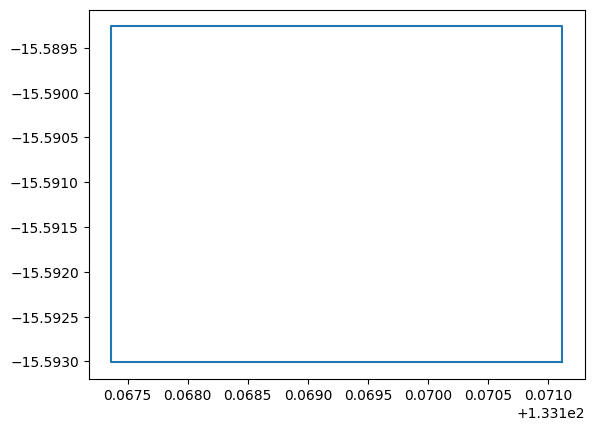

In [52]:
plt.plot(*np.array(p.exterior.coords).T)

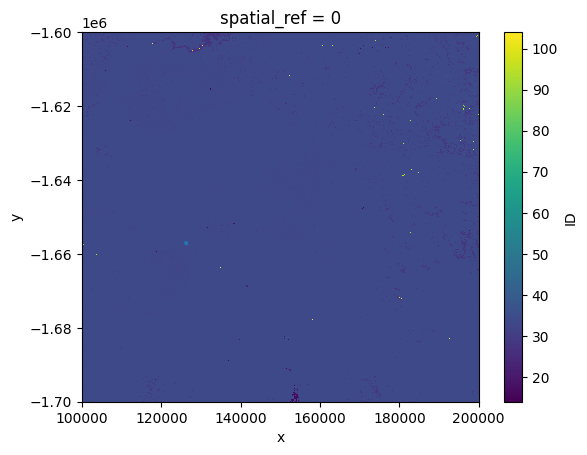

In [54]:
chip.plot()
plt.plot(*np.array(p.to_crs(chip.odc.crs).exterior.coords).T)

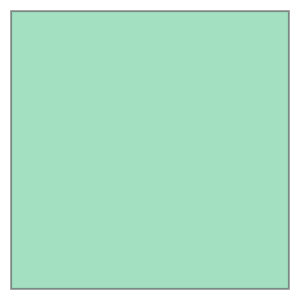

In [40]:
chip.odc.geobox.boundingbox.polygon

In [32]:
odc.geo.geom.intersects(chip.odc.geobox.boundingbox,p.boundingbox.to_crs(chip.odc.crs))

AttributeError: 'BoundingBox' object has no attribute 'intersects'

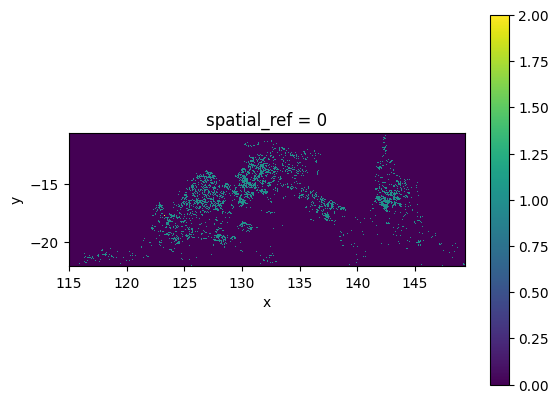

In [10]:
ax = merged.plot()
ax = plt.gca()
ax.set_aspect(1)
plt.gray()

In [12]:
len(polygons)

29180

In [120]:
m = odc.geo.geom.multigeom(polygons)

In [149]:
def get_unique_coords(poly):
    (x, y) = list(zip(*poly.exterior.coords))
    for interior in poly.interiors:
        for (xx, yy) in interior.coords:
            x = x + (xx,)
            y = y + (yy,)
    #interior = [[coord for coord in interior.coords] for interior in poly]
    return x,y

In [155]:
(x,y) = zip(*[get_unique_coords(p) for p in polygons])

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [153]:
k

((139.80861395247197,
  139.80861395247197,
  139.8048639522096,
  139.80111395284663,
  139.80111395284663,
  139.80111395284663,
  139.8048639522096,
  139.8048639522096,
  139.80861395247197),
 (-20.389259601731908,
  -20.393009601994134,
  -20.393009601994127,
  -20.393009601994127,
  -20.389259601731908,
  -20.38550960236905,
  -20.38550960236905,
  -20.389259601731908,
  -20.389259601731908))

In [143]:
list(zip(*k[0]))

[(139.81611395209714,
  139.81611395209714,
  139.81986395235955,
  139.81986395235955,
  139.81611395209714),
 (-20.423009602293156,
  -20.41925960203093,
  -20.41925960203094,
  -20.42300960229316,
  -20.423009602293156)]

In [138]:
m.geom.geoms[0].svg??

Signature: m.geom.geoms[0].svg(scale_factor=1.0, fill_color=None, opacity=None)
Source:   
    def svg(self, scale_factor=1.0, fill_color=None, opacity=None):
        """Returns SVG path element for the Polygon geometry.

        Parameters
        scale_factor : float
            Multiplication factor for the SVG stroke-width.  Default is 1.
        fill_color : str, optional
            Hex string for fill color. Default is to use "#66cc99" if
            geometry is valid, and "#ff3333" if invalid.
        opacity : float
            Float number between 0 and 1 for color opacity. Default value is 0.6
        """
        if self.is_empty:
            return "<g />"
        if fill_color is None:
            fill_color = "#66cc99" if self.is_valid else "#ff3333"
        if opacity is None:
            opacity = 0.6
        exterior_coords = [["{},{}".format(*c) for c in self.exterior.coords]]
        interior_coords = [
            ["{},{}".format(*c) for c in interior.coords] for in

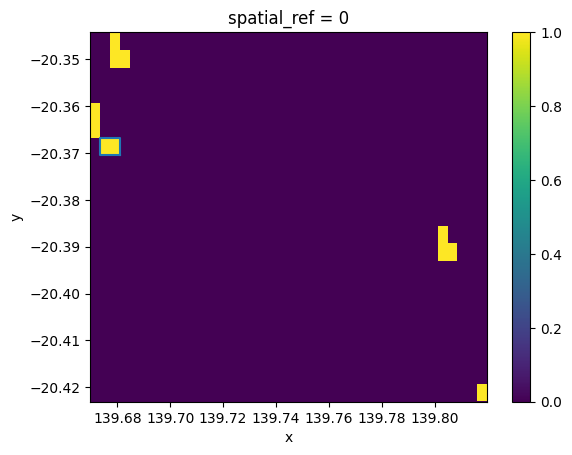

In [50]:
merged.plot()
plt.plot(*np.array(polygons[2].exterior.coords).T)

In [60]:
p = polygons[3]

In [65]:
s = {xy[0] for p in polygons for xy in p.exterior.coords}

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [64]:
s

{139.6698639526594, 139.67361395202235}

In [66]:
139.6698639526594-139.67361395202235

-0.0037499993629523942

In [157]:
1 / (111.32 * 1000)

8.98311174991017e-06

In [158]:
1 / 111.32

0.008983111749910169